In [1]:
# ===================================================================
# Cell 1: Setup and Imports
# ===================================================================
import pandas as pd
import numpy as np
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# For iSOM Data Generation
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

# For TabPFN Model
from tabpfn import TabPFNClassifier
from sklearn.metrics import f1_score, accuracy_score

# --- Installation Note ---
# !pip install tabpfn minisom sklearn pandas seaborn matplotlib tqdm

print("Setup Complete!")

Setup Complete!


In [2]:
# ===================================================================
# Cell 2: Helper Functions (iSOM Generator and Data Loaders)
# ===================================================================

def generate_isom_data(df_real, target_column, num_synthetic):
    if num_synthetic <= 0:
        return pd.DataFrame(columns=df_real.columns)
    
    X_real = df_real.drop(columns=[target_column]).values
    y_real = df_real[target_column].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_real)

    map_size = int(np.sqrt(5 * np.sqrt(X_scaled.shape[0])))
    som_grid_size = (map_size, map_size)
    
    som = MiniSom(som_grid_size[0], som_grid_size[1], X_scaled.shape[1],
                  sigma=1.0, learning_rate=0.5, random_seed=42)
    som.random_weights_init(X_scaled)
    som.train_random(X_scaled, 500)

    def get_neighbors(x, y, grid_size):
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size[0] and 0 <= ny < grid_size[1]:
                neighbors.append((nx, ny))
        return neighbors

    weights = som.get_weights()
    synthetic_samples = []
    rng = np.random.default_rng(42)

    for _ in range(num_synthetic):
        x1, y1 = rng.integers(som_grid_size[0]), rng.integers(som_grid_size[1])
        valid_neighbors = get_neighbors(x1, y1, som_grid_size)
        if not valid_neighbors: continue
        x2, y2 = rng.choice(valid_neighbors)
        node1_weights, node2_weights = weights[x1, y1], weights[x2, y2]
        alpha = rng.random()
        new_sample_scaled = alpha * node1_weights + (1 - alpha) * node2_weights
        distances = np.linalg.norm(X_scaled - new_sample_scaled, axis=1)
        new_target = y_real[np.argmin(distances)]
        synthetic_samples.append(np.append(new_sample_scaled, new_target))

    synthetic_df = pd.DataFrame(synthetic_samples, columns=df_real.columns)
    synthetic_features_scaled = synthetic_df.drop(columns=[target_column]).values
    synthetic_features_orig = scaler.inverse_transform(synthetic_features_scaled)
    synthetic_df[df_real.drop(columns=[target_column]).columns] = synthetic_features_orig
    synthetic_df[target_column] = synthetic_df[target_column].astype(int)
    return synthetic_df

def read_data(path):
    _, ext = os.path.splitext(path)
    if ext == ".parquet": return pd.read_parquet(path)
    elif ext == ".csv": return pd.read_csv(path, index_col=0)

def load_data(base_path):
    _, dataset_name = os.path.split(base_path)
    with open(os.path.join(base_path, f"{dataset_name}.meta.json")) as f: meta = json.load(f)
    train_data = read_data(os.path.join(base_path, f"{dataset_name}.{meta['format']}"))
    test_path = os.path.join(base_path, f"{dataset_name}_test.{meta['format']}")
    test_data = read_data(test_path) if os.path.exists(test_path) else train_data
    return train_data, test_data, meta

def get_indices_for_repeat(base_path, repeat_idx):
    train_idx_file = os.path.join(base_path, "train_indices.parquet")
    train_idx_splits = pd.read_parquet(train_idx_file)
    col_name = train_idx_splits.columns[repeat_idx]
    return train_idx_splits[col_name].values

print("Helper functions defined.")

Helper functions defined.


In [3]:
# ===================================================================
# Cell 3: Main Configuration
# ===================================================================
BASE_DATA_PATH = "data"
DATASETS_TO_RUN = [
    "framed_safety",
    "framed_validity"
]

REPEATS =1 # Number of random shuffles to run for each experiment

# --- Experiment Parameters ---
# We will run the augmentation experiment for all these starting fractions
FIXED_REAL_FRACTIONS = [0.1, 0.3] 
# And add these amounts of synthetic data
SYNTHETIC_ADD_FRACTIONS = np.arange(0.0, 0.4, 0.1).round(1)
# The baseline will cover all relevant real data fractions
BASELINE_REAL_FRACTIONS = np.arange(0.1, 0.6, 0.1).round(1)

In [4]:
# ===================================================================
# Cell 4: Main Experiment Loop
# ===================================================================
all_results = []
classifier = TabPFNClassifier(device="cuda")

for dataset_name in tqdm(DATASETS_TO_RUN, desc="Overall Dataset Progress"):
    print(f"\n===== Running Dataset: {dataset_name} =====")
    dataset_path = os.path.join(BASE_DATA_PATH, dataset_name)
    
    # Load data for the current dataset
    train_data, test_data, meta = load_data(dataset_path)
    X_columns, y_column = train_data.columns.drop(meta["label"]), meta["label"]
    X_test, y_test = test_data[X_columns], test_data[y_column]
    full_train_size = len(train_data)
    
    # This dataset may have a continuous target, so we convert it to binary classes
    if pd.api.types.is_float_dtype(train_data[y_column]):
        print(f"Dataset '{dataset_name}' has a continuous target. Converting to classes...")
        threshold = train_data[y_column].median()
        train_data[y_column] = (train_data[y_column] <= threshold).astype(int)
        test_data[y_column] = (test_data[y_column] <= threshold).astype(int)
        y_test = test_data[y_column] # Re-assign y_test with the new classes

    for i in range(REPEATS):
        shuffled_indices = get_indices_for_repeat(dataset_path, i)
        
        # --- Baseline Experiment ---
        for real_fraction in BASELINE_REAL_FRACTIONS:
            n_real = int(real_fraction * full_train_size)
            train_indices = shuffled_indices[:n_real]
            
            X_train = train_data.loc[train_indices, X_columns]
            y_train = train_data.loc[train_indices, y_column].astype(int)
            
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            
            score = f1_score(y_test.astype(int), y_pred, average="macro")
            all_results.append({"dataset": dataset_name,
                                "experiment": "Baseline (Real Only)", 
                                "total_fraction": real_fraction, 
                                "f1_score": score})

        # --- Incremental Augmentation Experiment ---
        for real_fraction in FIXED_REAL_FRACTIONS:
            n_real = int(real_fraction * full_train_size)
            real_indices = shuffled_indices[:n_real]
            train_subset_real = train_data.loc[real_indices]
            
            for synthetic_fraction in SYNTHETIC_ADD_FRACTIONS:
                n_synthetic = int(synthetic_fraction * full_train_size)
                
                # Generate synthetic data based on the fixed real subset
                print(f"Generating {n_synthetic} synthetic samples for {dataset_name} (repeat {i+1}, start {real_fraction})...")
                train_subset_synthetic = generate_isom_data(train_subset_real, y_column, n_synthetic)
                
                # Combine for training
                train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)
                X_train = train_augmented[X_columns]
                y_train = train_augmented[y_column].astype(int)
                
                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_test)
                
                score = f1_score(y_test.astype(int), y_pred, average="macro")
                total_fraction = round(real_fraction + synthetic_fraction, 1)
                all_results.append({"dataset": dataset_name,
                                    "experiment": f"Start {int(real_fraction*100)}% Real + iSOM", 
                                    "total_fraction": total_fraction, 
                                    "f1_score": score})

results_df = pd.DataFrame(all_results)
print("\n\n===== ALL EXPERIMENTS COMPLETE! =====")

Overall Dataset Progress:   0%|          | 0/2 [00:00<?, ?it/s]


===== Running Dataset: framed_safety =====


c:\Users\johnn\Documents\From Desktop\All things Python\env\lib\site-packages\tabpfn\architectures\base\attention\full_attention.py:678: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attention_head_outputs = torch.nn.functional.scaled_dot_product_attention(


Generating 0 synthetic samples for framed_safety (repeat 1, start 0.1)...


C:\Users\johnn\AppData\Local\Temp\ipykernel_7224\457590539.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 404 synthetic samples for framed_safety (repeat 1, start 0.1)...
Generating 809 synthetic samples for framed_safety (repeat 1, start 0.1)...
Generating 1213 synthetic samples for framed_safety (repeat 1, start 0.1)...
Generating 0 synthetic samples for framed_safety (repeat 1, start 0.3)...


C:\Users\johnn\AppData\Local\Temp\ipykernel_7224\457590539.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 404 synthetic samples for framed_safety (repeat 1, start 0.3)...
Generating 809 synthetic samples for framed_safety (repeat 1, start 0.3)...
Generating 1213 synthetic samples for framed_safety (repeat 1, start 0.3)...

===== Running Dataset: framed_validity =====
Dataset 'framed_validity' has a continuous target. Converting to classes...
Generating 0 synthetic samples for framed_validity (repeat 1, start 0.1)...


C:\Users\johnn\AppData\Local\Temp\ipykernel_7224\457590539.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 451 synthetic samples for framed_validity (repeat 1, start 0.1)...
Generating 902 synthetic samples for framed_validity (repeat 1, start 0.1)...
Generating 1353 synthetic samples for framed_validity (repeat 1, start 0.1)...
Generating 0 synthetic samples for framed_validity (repeat 1, start 0.3)...


C:\Users\johnn\AppData\Local\Temp\ipykernel_7224\457590539.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 451 synthetic samples for framed_validity (repeat 1, start 0.3)...
Generating 902 synthetic samples for framed_validity (repeat 1, start 0.3)...
Generating 1353 synthetic samples for framed_validity (repeat 1, start 0.3)...


===== ALL EXPERIMENTS COMPLETE! =====


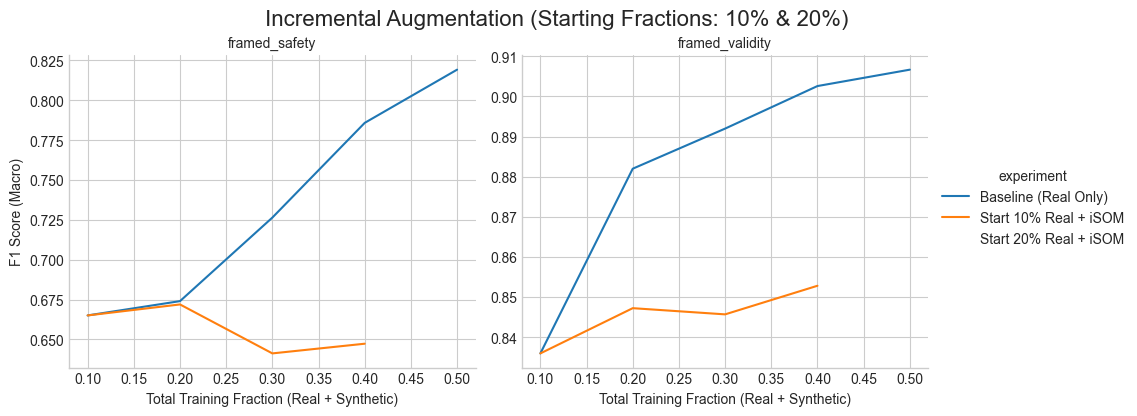

In [5]:
# ===================================================================
# Cell 5: Plotting - Set 1 (Start Fractions 10% & 20%) (Corrected)
# ===================================================================
plt.style.use('seaborn-v0_8-whitegrid')

experiments_to_plot_1 = [
    "Baseline (Real Only)",
    "Start 10% Real + iSOM",
    "Start 20% Real + iSOM"
]
df_plot_1 = results_df[results_df['experiment'].isin(experiments_to_plot_1)]

# Create the FacetGrid (this is correct)
g1 = sns.FacetGrid(
    df_plot_1, 
    col="dataset", 
    col_wrap=2, 
    hue="experiment",
    hue_order=experiments_to_plot_1,
    col_order=DATASETS_TO_RUN,
    height=4, 
    aspect=1.2, 
    sharey=False
)

# --- CORRECTED FIX ---
# Remove the 'style' argument from the map_dataframe call.
# 'hue' is already handling the separation of lines.
g1.map_dataframe(
    sns.lineplot,
    x="total_fraction",
    y="f1_score",
    markers=True, # markers are still good for clarity
    errorbar="sd"
).set_titles("{col_name}")

g1.set_axis_labels("Total Training Fraction (Real + Synthetic)", "F1 Score (Macro)")
g1.fig.suptitle("Incremental Augmentation (Starting Fractions: 10% & 20%)", y=1.03, fontsize=16)
g1.add_legend()

plt.show()

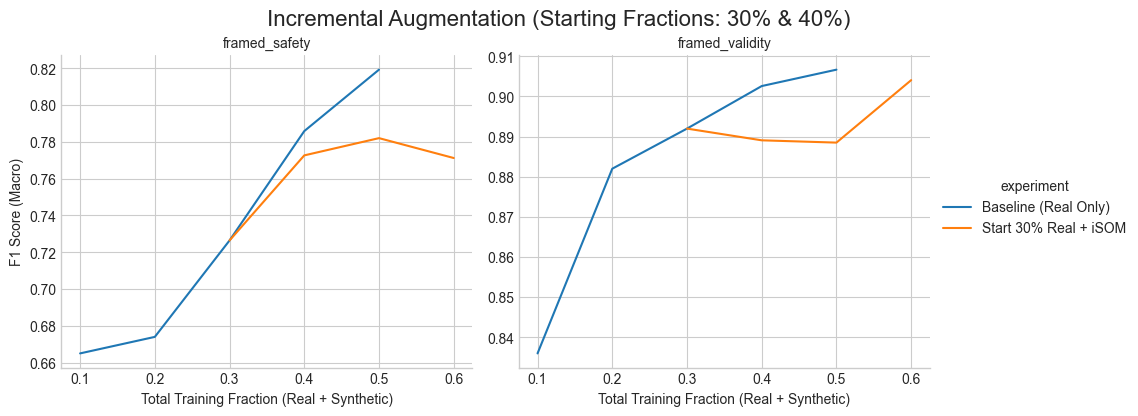

In [6]:
# ===================================================================
# Cell 6: Plotting - Set 2 (Start Fractions 30% & 40%) (Corrected)
# ===================================================================
plt.style.use('seaborn-v0_8-whitegrid')

experiments_to_plot_2 = [
    "Baseline (Real Only)",
    "Start 30% Real + iSOM"
]
df_plot_2 = results_df[results_df['experiment'].isin(experiments_to_plot_2)]

# Create the FacetGrid
g2 = sns.FacetGrid(
    df_plot_2, 
    col="dataset", 
    col_wrap=2, 
    hue="experiment",
    hue_order=experiments_to_plot_2,
    col_order=DATASETS_TO_RUN,
    height=4, 
    aspect=1.2, 
    sharey=False
)

# --- CORRECTED FIX ---
# Remove the 'style' argument here as well.
g2.map_dataframe(
    sns.lineplot,
    x="total_fraction",
    y="f1_score",
    markers=True,
    errorbar="sd"
).set_titles("{col_name}")

g2.set_axis_labels("Total Training Fraction (Real + Synthetic)", "F1 Score (Macro)")
g2.fig.suptitle("Incremental Augmentation (Starting Fractions: 30% & 40%)", y=1.03, fontsize=16)
g2.add_legend()

plt.show()